In [59]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from mlxtend.plotting import plot_decision_regions
from alibi.explainers import ALE, plot_ale


In [60]:
#raise
data = pd.read_csv("praca_piezometr.csv")
data = data.drop('waterlv', axis = 1)
data

,date,watertemp,sealv,precip,temp,vwind,dwind,sin,cos,precip1,precip2,precip3,precip4,precip5,precipsum,meantemp,raise
0,2008-09-28,12.49,479.33,0.90,13.15,7.75,255.00,-0.965926,-0.258819,0.00,0.00,0.00,0.00,0.00,0.00,11.116,False
1,2008-09-29,12.47,493.00,5.70,10.96,6.13,240.00,-0.866025,-0.500000,0.90,0.00,0.00,0.00,0.00,0.90,11.320,False
2,2008-09-30,12.44,492.00,2.40,10.29,6.13,207.50,-0.461749,-0.887011,5.70,0.90,0.00,0.00,0.00,6.60,11.340,False
3,2008-10-01,12.42,493.50,9.60,11.06,9.25,213.75,-0.555570,-0.831470,2.40,5.70,0.90,0.00,0.00,9.00,11.388,True
4,2008-10-02,12.40,497.83,0.00,10.30,11.38,220.00,-0.642788,-0.766044,9.60,2.40,5.70,0.90,0.00,18.60,11.692,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,2014-10-27,12.18,478.08,0.09,11.26,6.50,214.88,-0.571860,-0.820352,0.00,0.00,0.09,0.00,0.50,0.59,6.340,False
2125,2014-10-28,12.16,489.00,0.09,8.81,5.13,198.38,-0.315318,-0.948986,0.09,0.00,0.00,0.09,0.00,0.18,6.464,False
2126,2014-10-29,12.14,488.40,1.00,6.25,4.88,219.00,-0.629320,-0.777146,0.09,0.09,0.00,0.00,0.09,0.27,7.108,False
2127,2014-10-30,12.11,516.60,0.09,7.03,2.13,250.50,-0.942641,-0.333807,1.00,0.09,0.09,0.00,0.00,1.18,7.256,True


In [61]:
X_raise = data.drop(['raise', 'date'], axis=1)
y_raise = data['raise']

X_train_raise, X_test_raise, y_train_raise, y_test_raise = train_test_split(X_raise, y_raise, test_size=0.2, random_state=42)

In [62]:
#RF
model_raise_RF = RandomForestClassifier()
model_raise_RF.fit(X_train_raise, y_train_raise)

RandomForestClassifier()

In [63]:
trained = permutation_importance(model_raise_RF, X_train_raise, y_train_raise, n_repeats=30,random_state=0)
tested = permutation_importance(model_raise_RF, X_test_raise, y_test_raise, n_repeats=30,random_state=0)
importance_df = pd.DataFrame(zip(trained['importances_mean'], tested['importances_mean']), index=X_raise.columns, columns=["train", "test"])
importance_df_sorted = importance_df.sort_values(by='test', ascending=False)
importance_df_sorted

,train,test
sealv,0.089939,0.037793
vwind,0.040145,0.011268
watertemp,0.013114,0.004147
precip2,0.026052,0.002191
precip3,0.011881,0.000861
precip,0.007046,0.000861
cos,0.007712,0.000313
precip1,0.061910,0.000235
temp,0.006400,0.000156
meantemp,0.010393,-0.000861


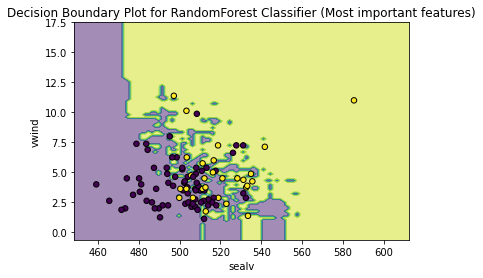

In [64]:

selected_features = ['sealv', 'vwind']


# Train the classifier on the selected features
X_selected = X_raise[selected_features].to_numpy()
RF = model_raise_RF.fit(X_selected, y_raise)

# Use DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(RF, X_selected, response_method="predict", xlabel='sealv', ylabel='vwind', alpha=0.5)
# Scatter plot with a subset of samples
sample_indices = np.random.choice(len(X_selected), size=100, replace=False)
X_sample = X_selected[sample_indices]
Y_sample = y_raise.iloc[sample_indices]  # Corrected variable name

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=Y_sample, edgecolor="k", s=30)

plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundary Plot for RandomForest Classifier (Most important features)')


# Show the plot
plt.show()

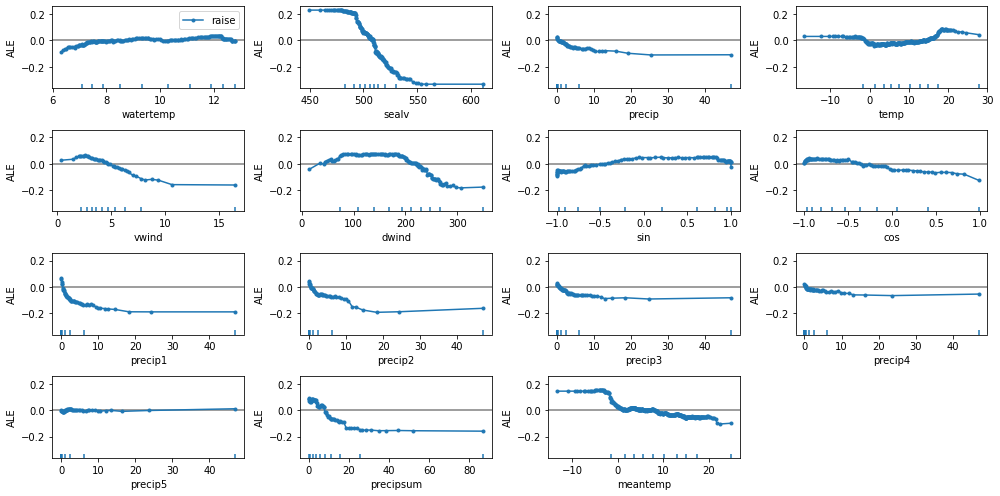

In [65]:
Xn, yn = X_raise.to_numpy(), y_raise.to_numpy()
reg_01a = RandomForestClassifier()
reg_01a.fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict_proba, feature_names=X_raise.columns, target_names=[y_raise.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

In [66]:
#GB
model_raise_XGB = XGBClassifier()
model_raise_XGB.fit(X_train_raise, y_train_raise)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
trained = permutation_importance(model_raise_XGB, X_train_raise, y_train_raise, n_repeats=30,random_state=0)
tested = permutation_importance(model_raise_XGB, X_test_raise, y_test_raise, n_repeats=30,random_state=0)
importance_df = pd.DataFrame(zip(trained['importances_mean'], tested['importances_mean']), index=X_raise.columns, columns=["train", "test"])
importance_df_sorted = importance_df.sort_values(by='test', ascending=False)
importance_df_sorted

,train,test
sealv,0.133255,0.078326
vwind,0.061675,0.037324
meantemp,0.064103,0.031299
precip2,0.020767,0.013850
watertemp,0.034155,0.013772
temp,0.046447,0.013380
precipsum,0.023997,0.004617
precip,0.003778,0.003052
dwind,0.004619,0.001643
precip5,0.002447,0.001565


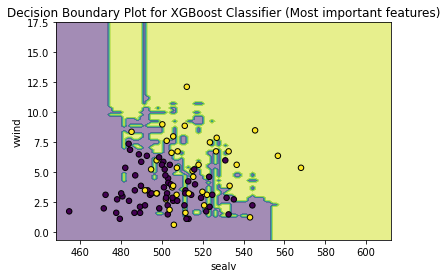

In [68]:
selected_features = ['sealv', 'vwind']

# Train the classifier on the selected features
X_selected = X_raise[selected_features].to_numpy()
XGB = model_raise_XGB.fit(X_selected, y_raise)

# Use DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(XGB, X_selected, response_method="predict", xlabel='sealv', ylabel='vwind', alpha=0.5)

# Scatter plot with a subset of samples
sample_indices = np.random.choice(len(X_selected), size=100, replace=False)
X_sample = X_selected[sample_indices]
Y_sample = y_raise.iloc[sample_indices]  # Corrected variable name

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=Y_sample, edgecolor="k", s=30)
# Set plot labels and title
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundary Plot for XGBoost Classifier (Most important features)')

# Show the plot
plt.show()

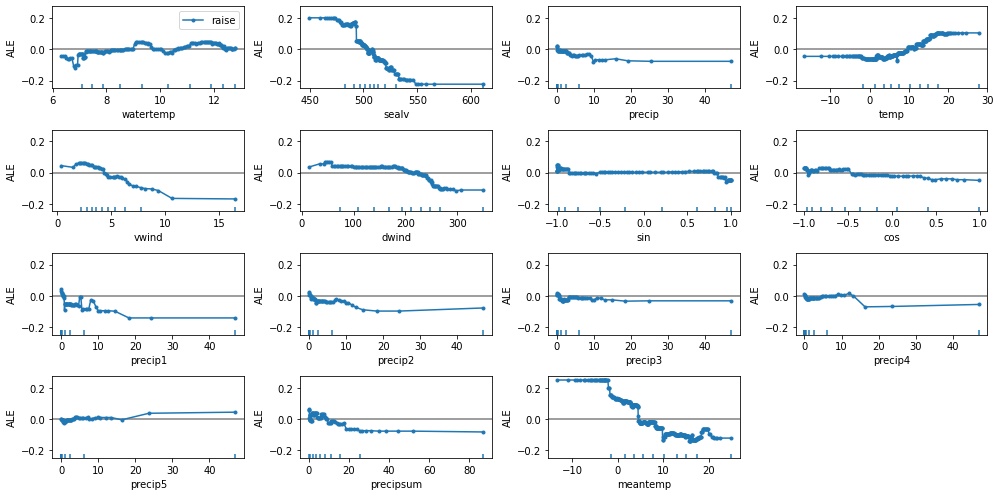

In [69]:
Xn, yn = X_raise.to_numpy(), y_raise.to_numpy()
reg_01a = XGBClassifier()
reg_01a.fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict_proba, feature_names=X_raise.columns, target_names=[y_raise.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

In [70]:
#KNN
model_raise_KNN = KNeighborsClassifier()
model_raise_KNN.fit(X_train_raise, y_train_raise)

KNeighborsClassifier()

In [71]:
trained = permutation_importance(model_raise_KNN, X_train_raise, y_train_raise, n_repeats=30,random_state=0)
tested = permutation_importance(model_raise_KNN, X_test_raise, y_test_raise, n_repeats=30,random_state=0)
importance_df = pd.DataFrame(zip(trained['importances_mean'], tested['importances_mean']), index=X_raise.columns, columns=["train", "test"])
importance_df_sorted = importance_df.sort_values(by='test', ascending=False)
importance_df_sorted

,train,test
sealv,0.094735,0.085524
dwind,0.119162,0.066197
precipsum,0.054414,0.025743
vwind,0.001938,0.011894
temp,0.012409,0.010798
precip2,0.003817,0.010329
meantemp,0.013877,0.008607
precip,0.005715,0.006729
watertemp,0.000372,0.006495
cos,0.000313,0.000078


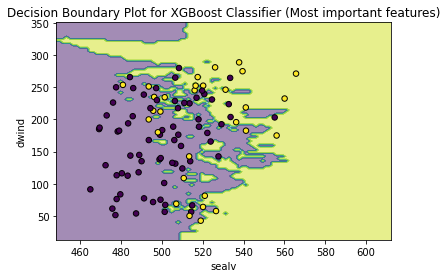

In [72]:
selected_features = ['sealv', 'dwind']

# Train the classifier on the selected features
X_selected = X_raise[selected_features].to_numpy()
KNN = model_raise_KNN.fit(X_selected, y_raise)

# Use DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(KNN, X_selected, response_method="predict", xlabel='sealv', ylabel='vwind', alpha=0.5)

# Scatter plot with a subset of samples
sample_indices = np.random.choice(len(X_selected), size=100, replace=False)
X_sample = X_selected[sample_indices]
Y_sample = y_raise.iloc[sample_indices]  # Corrected variable name

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=Y_sample, edgecolor="k", s=30)
# Set plot labels and title
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundary Plot for XGBoost Classifier (Most important features)')

# Show the plot
plt.show()

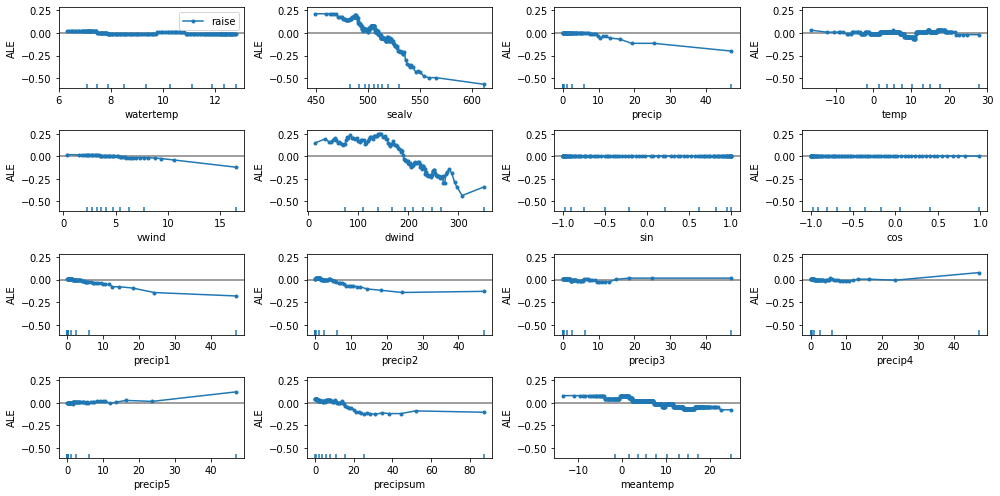

In [73]:
Xn, yn = X_raise.to_numpy(), y_raise.to_numpy()
reg_01a = KNeighborsClassifier()
reg_01a.fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict_proba, feature_names=X_raise.columns, target_names=[y_raise.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

In [74]:
#waterlv
data2 = pd.read_csv("praca_piezometr.csv")
data2 = data2.drop('raise', axis = 1)
data2

,date,watertemp,sealv,precip,temp,vwind,dwind,sin,cos,precip1,precip2,precip3,precip4,precip5,precipsum,meantemp,waterlv
0,2008-09-28,12.49,479.33,0.90,13.15,7.75,255.00,-0.965926,-0.258819,0.00,0.00,0.00,0.00,0.00,0.00,11.116,62.59
1,2008-09-29,12.47,493.00,5.70,10.96,6.13,240.00,-0.866025,-0.500000,0.90,0.00,0.00,0.00,0.00,0.90,11.320,61.62
2,2008-09-30,12.44,492.00,2.40,10.29,6.13,207.50,-0.461749,-0.887011,5.70,0.90,0.00,0.00,0.00,6.60,11.340,61.48
3,2008-10-01,12.42,493.50,9.60,11.06,9.25,213.75,-0.555570,-0.831470,2.40,5.70,0.90,0.00,0.00,9.00,11.388,61.23
4,2008-10-02,12.40,497.83,0.00,10.30,11.38,220.00,-0.642788,-0.766044,9.60,2.40,5.70,0.90,0.00,18.60,11.692,61.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,2014-10-27,12.18,478.08,0.09,11.26,6.50,214.88,-0.571860,-0.820352,0.00,0.00,0.09,0.00,0.50,0.59,6.340,54.92
2125,2014-10-28,12.16,489.00,0.09,8.81,5.13,198.38,-0.315318,-0.948986,0.09,0.00,0.00,0.09,0.00,0.18,6.464,54.08
2126,2014-10-29,12.14,488.40,1.00,6.25,4.88,219.00,-0.629320,-0.777146,0.09,0.09,0.00,0.00,0.09,0.27,7.108,54.08
2127,2014-10-30,12.11,516.60,0.09,7.03,2.13,250.50,-0.942641,-0.333807,1.00,0.09,0.09,0.00,0.00,1.18,7.256,53.33


In [75]:
X_waterlv = data2.drop(['waterlv', 'date'], axis=1)
y_waterlv = data2['waterlv']

X_train_waterlv, X_test_waterlv, y_train_waterlv, y_test_waterlv= train_test_split(X_waterlv, y_waterlv, test_size=0.2, random_state=42)

In [76]:
model_waterlv_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_waterlv_RF.fit(X_train_waterlv, y_train_waterlv)

RandomForestRegressor(random_state=42)

In [77]:
trained = permutation_importance(model_waterlv_RF, X_train_waterlv, y_train_waterlv, n_repeats=30,random_state=0)
tested = permutation_importance(model_waterlv_RF, X_test_waterlv, y_test_waterlv, n_repeats=30,random_state=0)
importance_df = pd.DataFrame(zip(trained['importances_mean'], tested['importances_mean']), index=X_waterlv.columns, columns=["train", "test"])
importance_df_sorted = importance_df.sort_values(by='test', ascending=False)
importance_df_sorted

,train,test
sealv,0.690213,0.531896
meantemp,0.439518,0.330408
watertemp,0.451727,0.306571
temp,0.183873,0.086429
precipsum,0.086150,0.056802
dwind,0.021388,0.011902
vwind,0.037121,0.011673
sin,0.022826,0.008691
cos,0.029346,0.008571
precip1,0.047319,0.007020


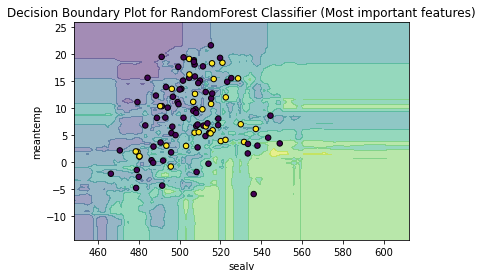

In [78]:
selected_features = ['sealv', 'meantemp']

# Train the classifier on the selected features
X_selected = X_waterlv[selected_features].to_numpy()
RF = model_waterlv_RF.fit(X_selected, y_waterlv)

# Use DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(RF, X_selected, response_method="predict", xlabel='sealv', ylabel='meantemp', alpha=0.5)

# Scatter plot with a subset of samples
sample_indices = np.random.choice(len(X_selected), size=100, replace=False)
X_sample = X_selected[sample_indices]
Y_sample = y_raise.iloc[sample_indices]  # Corrected variable name

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=Y_sample, edgecolor="k", s=30)

# Set plot labels and title
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundary Plot for RandomForest Classifier (Most important features)')

# Show the plot
plt.show()

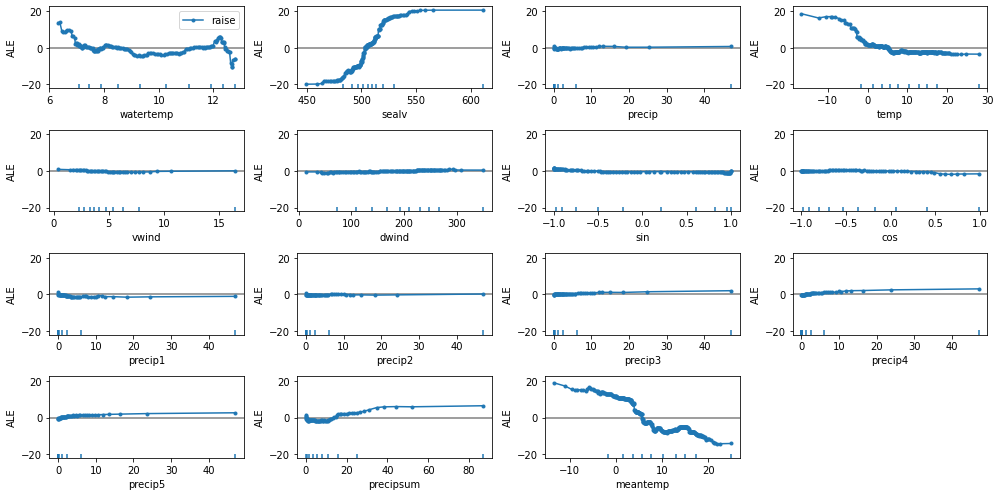

In [79]:
Xn, yn = X_waterlv.to_numpy(), y_waterlv.to_numpy()
reg_01a = RandomForestRegressor()
reg_01a.fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict, feature_names=X_raise.columns, target_names=[y_raise.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

In [80]:
#GB
model_waterlv_XGB = XGBRegressor()
model_waterlv_XGB.fit(X_train_waterlv, y_train_waterlv)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [81]:
trained = permutation_importance(model_waterlv_XGB, X_train_waterlv, y_train_waterlv, n_repeats=30,random_state=0)
tested = permutation_importance(model_waterlv_XGB, X_test_waterlv, y_test_waterlv, n_repeats=30,random_state=0)
importance_df = pd.DataFrame(zip(trained['importances_mean'], tested['importances_mean']), index=X_waterlv.columns, columns=["train", "test"])
importance_df_sorted = importance_df.sort_values(by='test', ascending=False)
importance_df_sorted

,train,test
sealv,0.545336,0.508422
watertemp,0.463007,0.380411
meantemp,0.367971,0.364743
temp,0.168285,0.104215
precipsum,0.109825,0.102364
dwind,0.042545,0.023467
precip5,0.036032,0.010393
precip4,0.027729,0.009403
precip,0.023078,0.008403
cos,0.042092,0.007897


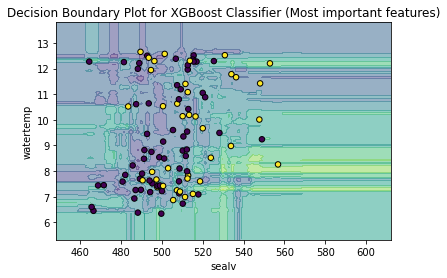

In [82]:
selected_features = ['sealv', 'watertemp']

# Train the classifier on the selected features
X_selected = X_waterlv[selected_features].to_numpy()
XGB = model_waterlv_XGB.fit(X_selected, y_waterlv)

# Use DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(XGB, X_selected, response_method="predict", xlabel='sealv', ylabel='meantemp', alpha=0.5)

# Scatter plot with a subset of samples
sample_indices = np.random.choice(len(X_selected), size=100, replace=False)
X_sample = X_selected[sample_indices]
Y_sample = y_raise.iloc[sample_indices]  # Corrected variable name

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=Y_sample, edgecolor="k", s=30)
# Set plot labels and title
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundary Plot for XGBoost Classifier (Most important features)')

# Show the plot
plt.show()

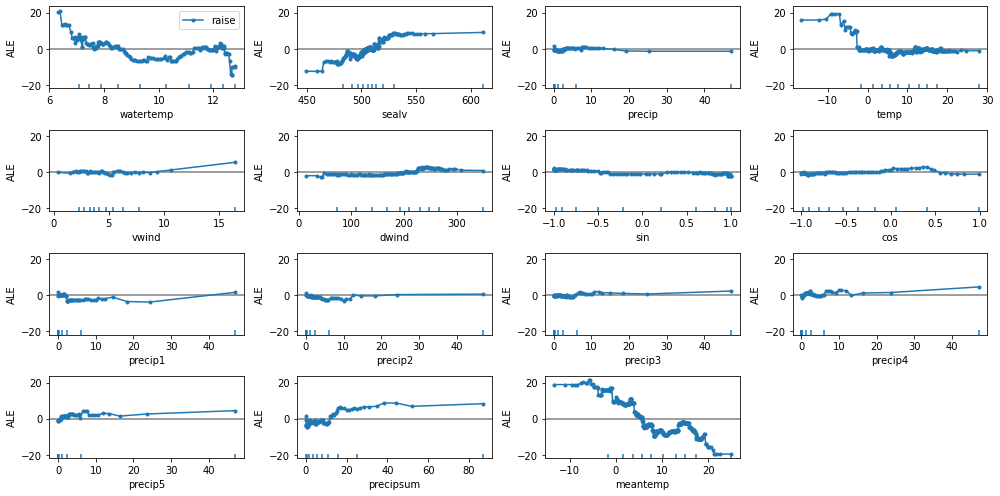

In [83]:
Xn, yn = X_waterlv.to_numpy(), y_waterlv.to_numpy()
reg_01a = XGBRegressor()
reg_01a.fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict, feature_names=X_raise.columns, target_names=[y_raise.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})

In [84]:
#KNN
model_waterlv_KNN = KNeighborsRegressor()
model_waterlv_KNN.fit(X_train_raise, y_train_raise)

KNeighborsRegressor()

In [85]:
trained = permutation_importance(model_waterlv_KNN, X_train_raise, y_train_raise, n_repeats=30,random_state=0)
tested = permutation_importance(model_waterlv_KNN, X_test_raise, y_test_raise, n_repeats=30,random_state=0)
importance_df = pd.DataFrame(zip(trained['importances_mean'], tested['importances_mean']), index=X_waterlv.columns, columns=["train", "test"])
importance_df_sorted = importance_df.sort_values(by='test', ascending=False)
importance_df_sorted

,train,test
sealv,0.305639,0.280958
dwind,0.382650,0.214577
precipsum,0.152768,0.093761
temp,0.037158,0.051859
meantemp,0.033904,0.044014
vwind,0.010451,0.028958
precip2,0.014457,0.028549
precip4,0.008535,0.015268
precip,0.022370,0.010690
watertemp,0.001427,0.005746


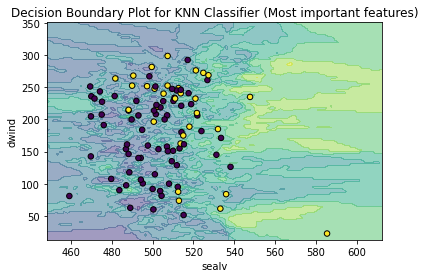

In [86]:
selected_features = ['sealv', 'dwind']

# Train the classifier on the selected features
X_selected = X_waterlv[selected_features].to_numpy()
KNN = model_waterlv_KNN.fit(X_selected, y_waterlv)

# Use DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(KNN, X_selected, response_method="predict", xlabel='sealv', ylabel='meantemp', alpha=0.5)

# Scatter plot with a subset of samples
sample_indices = np.random.choice(len(X_selected), size=100, replace=False)
X_sample = X_selected[sample_indices]
Y_sample = y_raise.iloc[sample_indices]  # Corrected variable name

plt.scatter(X_sample[:, 0], X_sample[:, 1], c=Y_sample, edgecolor="k", s=30)
# Set plot labels and title
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title('Decision Boundary Plot for KNN Classifier (Most important features)')

# Show the plot
plt.show()

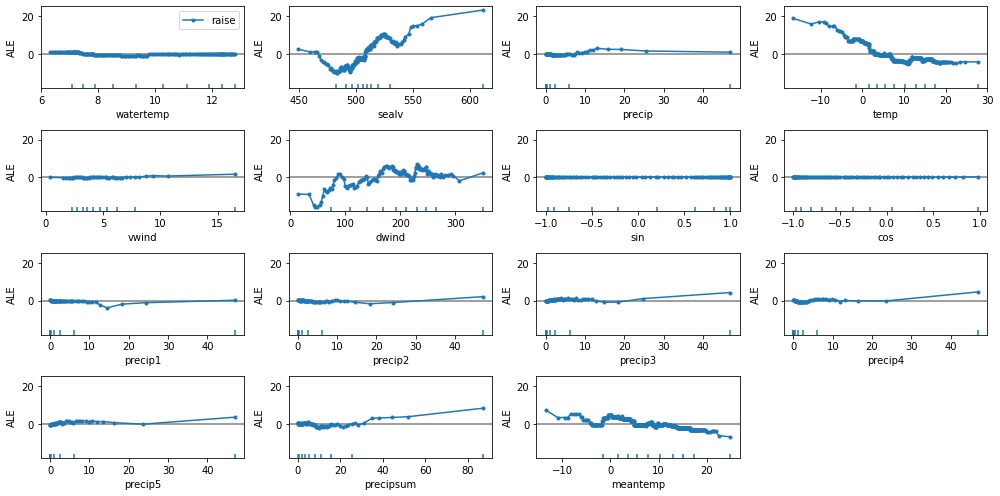

In [87]:
Xn, yn = X_waterlv.to_numpy(), y_waterlv.to_numpy()
reg_01a = KNeighborsRegressor()
reg_01a.fit(Xn, yn)
reg_01_ale = ALE(reg_01a.predict, feature_names=X_raise.columns, target_names=[y_raise.name])
reg_01_ale_exp = reg_01_ale.explain(Xn)
_ = plot_ale(reg_01_ale_exp, n_cols=4, fig_kw={'figwidth':14, 'figheight': 7})